In [1]:
import sys
import time
import struct
import subprocess
import multiprocessing
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as ss

In [2]:
def get_raw_data_from_file(fname,offset_samples,duration_samples, file_parameters=(125000,16,3)):
    if fname[-3::]=='.wv':
        data_raw=subprocess.check_output(
            ['wvunpack','-q','-r',
             '--skip='+str(offset_samples),
             '--until=+'+str(duration_samples),
             fname,'-'],
            shell=True)
    if fname[-4::]=='.bin':        
        sr=file_parameters[0]
        bd=file_parameters[1]
        nc=file_parameters[2]
        offset_bytes=offset_samples*int(bd/8)*nc*2
        duration_bytes=duration_samples*int(bd/8)*nc*2
#        print(duration_samples,bd,nc,duration_bytes)
        f = open(fname, 'rb')
        fsize=f.seek(0,2)
        f.seek(offset_bytes)        
        data_raw=f.read(duration_bytes)
        f.close()
    if fname[-4::]=='.wav':
        print('oops')
        
    return data_raw

In [3]:
# Input parameters
t = time.time()
wv_filename="04061417_part01.wv"
bin_filename="04061417.bin"
fig_filename="doppler_shifts_mpl_mp2.png"
file_parameters=(1000000,16,2)
data_filename=bin_filename
z_filename= "doppler_shifts.z"
mat_filename="phase.mat"
n_ch=file_parameters[2]*2 # number of channels
fd=file_parameters[0] # sample frequency (Hz)
period_sec=0.1 # interpulse period (seconds)
num_pulses=3300 # number of pulses
offset_bytes=41151200 
f_min=-425000 # low start frequency (Hz)
f_bandwidth=850000 # frequency bandwidth (Hz)
f_center=5400000
f_step=1000 # frequency step (Hz)
l_c_freq=100 # low cutoff frequency (Hz)
f_order=3 # filter order
period=period_sec*fd
#scale_factor=0.5/32768
scale_factor=0.5/32767
win=4000 # window size in samples
win2=900 # window2 size in samples
del_rw=2550+275 # delay of the reflected signal in samples
vmin=-0.2
vmax=0.9

In [4]:
# Arrray initializations
w_axe1=np.arange(f_min+fd,fd,f_step)*2*np.pi/fd
w_axe2=np.arange(0,-f_min,f_step)*2*np.pi/fd
w_axe=np.concatenate((w_axe1,w_axe2), axis=0)

rwr_mat=np.zeros((num_pulses, win2))
rwi_mat=np.zeros((num_pulses, win2))

rw_ind_mat=np.zeros((num_pulses, win2))

#rw_pha_mat=np.zeros((len(w_axe),num_pulses))
doppler_shifts=np.zeros((len(w_axe),num_pulses-1))

unpack_str="<"+str(n_ch*win)+"h"

rwcr_zf_list=[np.zeros((2,2)) for i in range(len(w_axe))]
rwci_zf_list=[np.zeros((2,2)) for i in range(len(w_axe))]

In [5]:
# Filling of Arrays (DATA loading)
# for pulse_counter in range(0,num_pulses):
ind=1
for pulse_counter in range(0,ind+1):
    skip_val=int(offset_bytes/2/n_ch)+int(period*(pulse_counter))
    ind_axe_start=skip_val
    ind_axe_all=np.arange(ind_axe_start,ind_axe_start+win) # samples axe for 4000-window
    data_bytes=get_raw_data_from_file(data_filename, skip_val, win, file_parameters=file_parameters)
    data=struct.unpack(unpack_str,data_bytes)
    data_scaled=np.reshape(data,[int(len(data)/n_ch), n_ch])*scale_factor


    rwOr_data=data_scaled[del_rw:del_rw+win2,0] # O-mode reflected wave's real data
    rwOi_data=data_scaled[del_rw:del_rw+win2,1] # O-mode reflected wave's imagenary data        
    rwXr_data=data_scaled[del_rw:del_rw+win2,2] # X-mode reflected wave's real data
    rwXi_data=data_scaled[del_rw:del_rw+win2,3] # X-mode reflected wave's imagenary data        
#     print(pulse_counter)
    rwr_mat[pulse_counter,:]=rwOr_data+rwXi_data
    rwi_mat[pulse_counter,:]=rwOi_data-rwXr_data

    rw_ind_mat[pulse_counter,:]=ind_axe_all[del_rw:(del_rw+win2)]

In [6]:
rwr=rwr_mat[ind,:]
rwi=rwr_mat[ind,:]

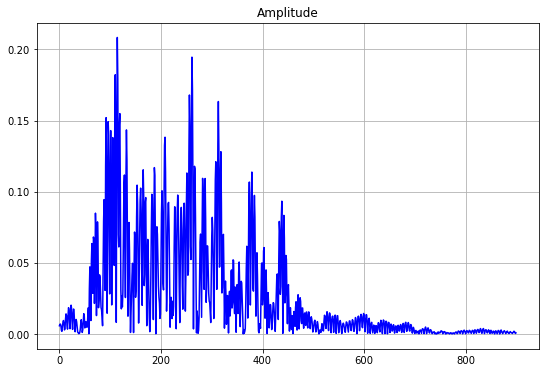

In [7]:
fig = plt.figure(figsize=(9,6))
ax1 = plt.subplot(1,1,1)
plt.plot(np.sqrt(rwr**2+rwi**2),c='b')
plt.title("Amplitude")
plt.grid()
plt.show()

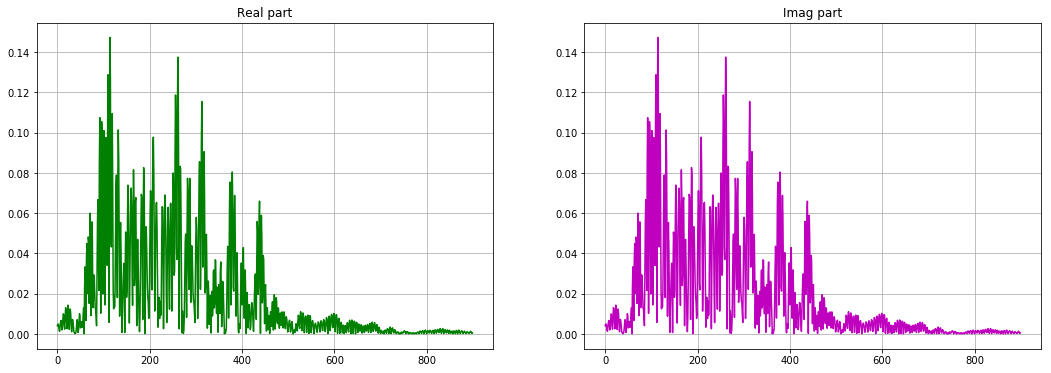

In [8]:
fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
plt.plot(np.abs(rwr),c='g')
plt.title("Real part")
plt.grid()
ax2 = plt.subplot(1,2,2)
plt.plot(np.abs(rwi),c='m')
plt.title("Imag part")
plt.grid()
plt.show()

In [79]:
660-270

390

In [9]:
# l_c=l_c_freq
l_c=100
print("f_order = " + str(f_order))
print("l_c = " + str(l_c))
sos_coefs = ss.iirfilter(f_order, (2**.5)*2*l_c/fd, btype='lowpass', analog=False, ftype='bessel', output='sos')
print(sos_coefs)

f_order = 3
l_c = 100
[[  8.76042771e-11   1.75208554e-10   8.76042771e-11   1.00000000e+00
   -9.99163666e-01   0.00000000e+00]
 [  1.00000000e+00   1.00000000e+00   0.00000000e+00   1.00000000e+00
   -1.99867492e+00   9.98675760e-01]]


[[  1.21655522e-11   4.81239353e-14]
 [  7.47461777e-06  -7.44986360e-06]]
[[  1.21655522e-11   4.81239353e-14]
 [  7.47461777e-06  -7.44986360e-06]]


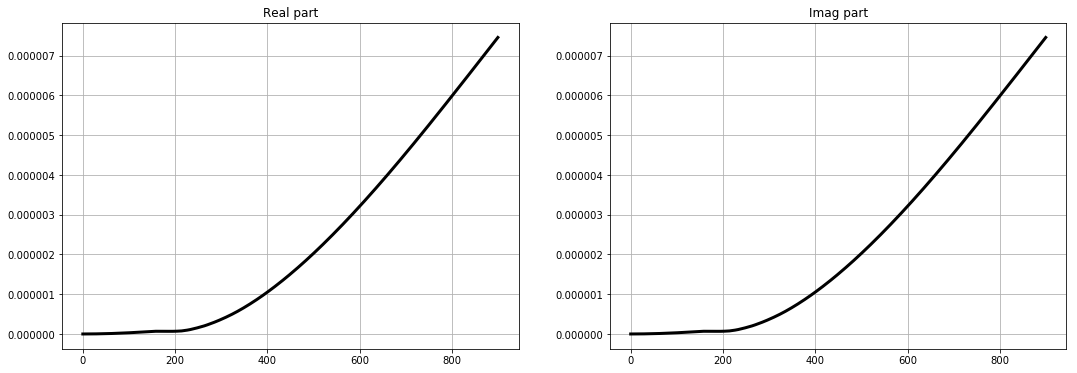

In [13]:
rwr_zi_start = np.zeros((2,2))
rwi_zi_start = np.zeros((2,2))
rwr_filt, rwr_zi_end = ss.sosfilt(sos_coefs, rwr, zi=rwr_zi_start)
rwi_filt, rwi_zi_end = ss.sosfilt(sos_coefs, rwi, zi=rwi_zi_start)
print(rwr_zi_end)
print(rwi_zi_end)

fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
# plt.plot(np.abs(rwr),c='g')
plt.plot(np.abs(rwr_filt),c='k',lw=3)
plt.title("Real part")
plt.grid()
ax2 = plt.subplot(1,2,2)
# plt.plot(np.abs(rwi),c='m')
plt.plot(np.abs(rwi_filt),c='k',lw=3)
plt.title("Imag part")
plt.grid()
plt.show()

In [21]:
def my_lfilter(b, a, x, zi):
    y=np.zeros_like(x)
    zf=zi
    for i in range(len(x)):        
        y[i]  = zf[0] + b[0]*x[i]
        zf[0] = zf[1] + x[i]*b[1]-y[i]*a[1]
        zf[1] =         x[i]*b[2]-y[i]*a[2]   
    return y, zf

In [22]:
def my_sosfilt(sos, x, zi):
    n_sections = sos.shape[0] # = 2 in my case
    zf = np.zeros_like(zi)
    for section in range(n_sections):
            x, zf[section] = my_lfilter(sos[section, :3], sos[section, 3:], x, zi[section])                        
    return x, zf

0.0
0.0


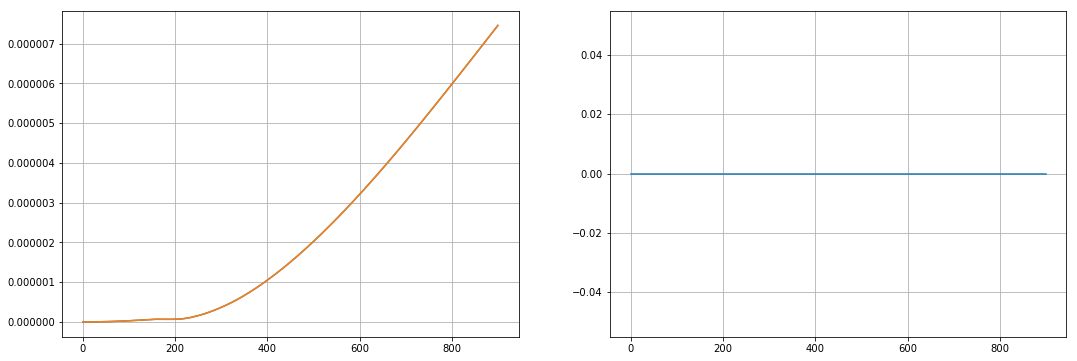

In [19]:
rwr_my_zf=np.zeros((2,2))
rwr_zf=np.zeros((2,2))
rwr_myfilt,rwr_my_zf[0]=ss.lfilter(sos_coefs[0, :3], sos_coefs[0, 3:],rwr,zi=rwr_zi_start[0])
rwr_myfilt,rwr_my_zf[1]=ss.lfilter(sos_coefs[1, :3], sos_coefs[1, 3:],rwr_myfilt,zi=rwr_zi_start[1])
rwr_filt,rwr_zf[0]=ss.lfilter(sos_coefs[0, :3], sos_coefs[0, 3:],rwr,zi=rwr_zi_start[0])
rwr_filt,rwr_zf[1]=ss.lfilter(sos_coefs[1, :3], sos_coefs[1, 3:],rwr_filt,zi=rwr_zi_start[1])
print(np.max(np.abs(rwr_filt-rwr_myfilt)))
print(np.max(np.abs(rwr_my_zf-rwr_zf)))
fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
# plt.plot(np.abs(rwr),c='g')
# plt.plot(rwr)
plt.plot(rwr_myfilt)
plt.plot(rwr_filt)
plt.grid()
ax2 = plt.subplot(1,2,2)
plt.plot(rwr_myfilt-rwr_filt)
plt.grid()
plt.show()

In [23]:
rwr_filt_my, rwr_zi_end_my = my_sosfilt(sos_coefs, rwr, zi=rwr_zi_start)
rwi_filt_my, rwi_zi_end_my = my_sosfilt(sos_coefs, rwi, zi=rwi_zi_start)
print(rwr_zi_end_my)
print(rwi_zi_end_my)

[[  1.21655522e-11   4.81239353e-14]
 [  7.47461777e-06  -7.44986360e-06]]
[[  1.21655522e-11   4.81239353e-14]
 [  7.47461777e-06  -7.44986360e-06]]


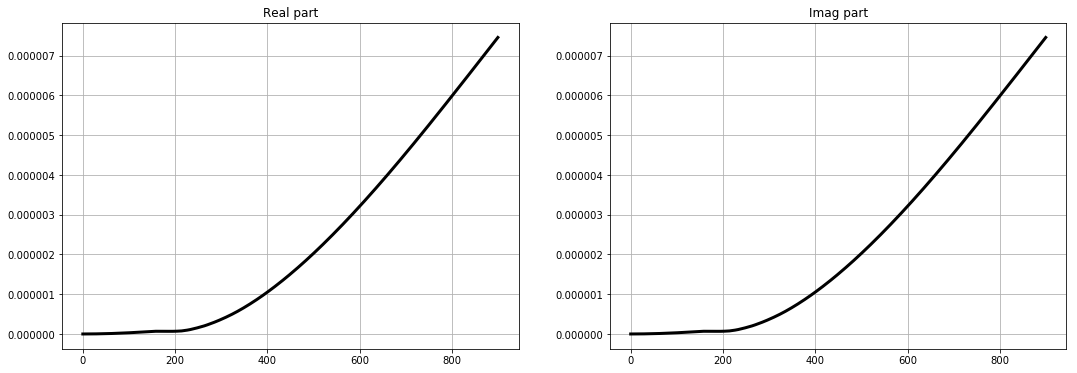

In [24]:
fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
# plt.plot(np.abs(rwr),c='g')
plt.plot(np.abs(rwr_filt_my),c='k',lw=3)
plt.title("Real part")
plt.grid()
ax2 = plt.subplot(1,2,2)
# plt.plot(np.abs(rwi),c='m')
plt.plot(np.abs(rwi_filt_my),c='k',lw=3)
plt.title("Imag part")
plt.grid()
plt.show()

In [25]:
print(rwr_zi_end-rwr_zi_end_my)
print(rwi_zi_end-rwi_zi_end_my)

[[ 0.  0.]
 [ 0.  0.]]
[[ 0.  0.]
 [ 0.  0.]]


0.0
0.0


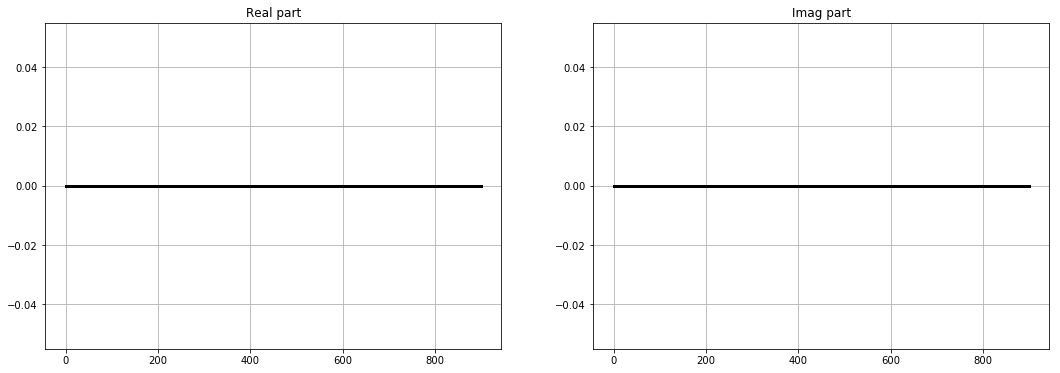

In [26]:
print(np.max(rwr_filt-rwr_filt_my))
print(np.max(rwi_filt-rwi_filt_my))
fig = plt.figure(figsize=(18,6))
ax1 = plt.subplot(1,2,1)
# plt.plot(np.abs(rwr),c='g')
plt.plot(np.abs(rwr_filt-rwr_filt_my),c='k',lw=3)
plt.title("Real part")
plt.grid()
ax2 = plt.subplot(1,2,2)
# plt.plot(np.abs(rwi),c='m')
plt.plot(np.abs(rwi_filt-rwi_filt_my),c='k',lw=3)
plt.title("Imag part")
plt.grid()
plt.show()